## Installing OpenVino Library [$\Uparrow$](#Table-of-content:)


In [1]:
%pip install -q "openvino>=2023.1.0" "nncf>=2.5.0"

Note: you may need to restart the kernel to use updated packages.


## Check model inference [$\Uparrow$](#Table-of-content:)

`detect.py` script run pytorch model inference and save image as result,

In [5]:
!python -W ignore detect.py --weights best.pt --conf 0.25 --img-size 640 --source pothole_road.mp4

Namespace(weights=['best.pt'], source='pothole_road.mp4', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/360) d:\pothole\yolov7-main\pothole_road.mp4: 1 pothole, Done. (16.4ms) Inference, (1733.3ms) NMS
video 1/1 (2/360) d:\pothole\yolov7-main\pothole_road.mp4: 1 pothole, Done. (54.4ms) Inference, (3.0ms) NMS
video 1/1 (3/360) d:\pothole\yolov7-main\pothole_road.mp4: Done. (58.7ms) Inference, (0.5ms) NMS
video 1/1 (4/360) d:\pothole\yolov7-main\pothole_road.mp4: Done. (49.4ms) Inference, (0.0ms) NMS
video 1/1 (5/360) d:\pothole\yolov7-main\pothole_road.mp4: 1 pothole, Done. (48.6ms)

YOLOR  2023-1-1 torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6143.5MB)

Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


In [6]:
!python -W ignore detect.py --weights best.pt --conf 0.25 --img-size 640 --source 1.jpg

Namespace(weights=['best.pt'], source='1.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

4 potholes, Done. (55.0ms) Inference, (0.0ms) NMS
 The image with the result is saved in: runs\detect\exp2\1.jpg
Done. (0.084s)


YOLOR  2023-1-1 torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6143.5MB)

Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


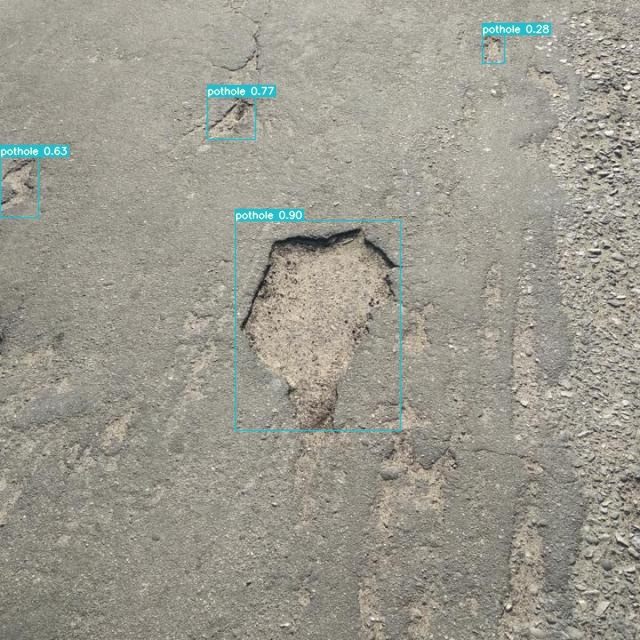

In [8]:
from PIL import Image
Image.open('runs/detect/exp/1.jpg')

## Export to ONNX [$\Uparrow$](#Table-of-content:)


In [11]:
!python -W ignore export.py --weights best.pt --grid

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='best.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=False, max_wh=None, topk_all=100, iou_thres=0.45, conf_thres=0.25, device='cpu', simplify=False, include_nms=False, fp16=False, int8=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse

Starting TorchScript export with torch 1.11.0+cu113...
TorchScript export success, saved as best.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.11.0+cu113...
TorchScript-Lite export success, saved as best.torchscript.ptl

Starting ONNX export with onnx 1.14.1...
ONNX export success, saved as best.onnx

Export complete (28.72s). Visualize with https://github.com/lutzroeder/netron.


YOLOR  2023-1-1 torch 1.11.0+cu113 CPU

Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


## Convert ONNX Model to OpenVINO Intermediate Representation (IR) [$\Uparrow$](#Table-of-content:)


In [12]:
import openvino as ov

model = ov.convert_model('./best.onnx')

ov.save_model(model, './best.xml')

## Verify model inference [$\Uparrow$](#Table-of-content:)



### Preprocessing [$\Uparrow$](#Table-of-content:)



In [13]:
import numpy as np
import torch
from PIL import Image
from utils.datasets import letterbox
from utils.plots import plot_one_box


def preprocess_image(img0: np.ndarray):
    
    
    img = letterbox(img0, auto=False)[0]
    
    
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor



DEFAULT_NAMES = ['pothole']


state_dict = torch.load("./best.pt", map_location="cpu")
if hasattr(state_dict["model"], "module"):
    NAMES = getattr(state_dict["model"].module, "names", DEFAULT_NAMES)
else:
    NAMES = getattr(state_dict["model"], "names", DEFAULT_NAMES)

del state_dict


COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(NAMES)}

### Postprocessing [$\Uparrow$](#Table-of-content:)



In [14]:
Path="./1.jpg"

In [15]:
from typing import List, Tuple, Dict
from utils.general import scale_coords, non_max_suppression


def detect(model: ov.Model, image_path: Path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    
    output_blob = model.output(0)
    img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

In [16]:
core = ov.Core()

model = core.read_model('./best.xml')

### Select inference device [$\Uparrow$](#Table-of-content:)



In [17]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [18]:

compiled_model = core.compile_model(model, device.value)

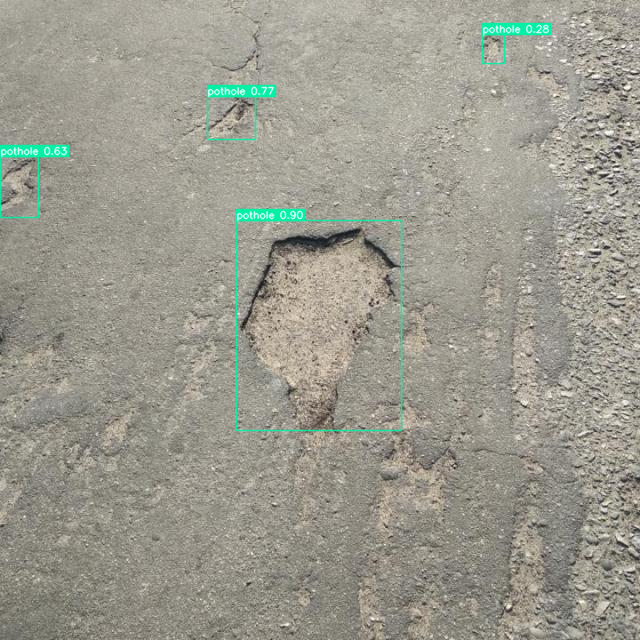

In [20]:
boxes, image, input_shape = detect(compiled_model, './1.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)

Image.fromarray(image_with_boxes)

## Verify model accuracy [$\Uparrow$](#Table-of-content:)


In [21]:
from collections import namedtuple
import yaml
from utils.datasets import create_dataloader
from utils.general import check_dataset, box_iou, xywh2xyxy, colorstr


DATA_CONFIG = 'data/custom_data.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)
val="./data/val"
# Dataloader
TASK = 'val'   
Option = namedtuple('Options', ['single_cls']) 
opt = Option(False)
dataloader = create_dataloader(
    data[TASK], 640, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)[0]

val: Scanning 'data\val\labels.cache' images and labels... 153 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 153/153 [00:00<?, ?it/s]


### Define validation function [$\Uparrow$](#Table-of-content:)



In [22]:
import numpy as np
from tqdm.notebook import tqdm
from utils.metrics import ap_per_class
from openvino.runtime import Tensor


def test(data,
         model: ov.Model,
         dataloader: torch.utils.data.DataLoader,
         conf_thres: float = 0.001,
         iou_thres: float = 0.65,  # for NMS
         single_cls: bool = False,
         v5_metric: bool = False,
         names: List[str] = None,
         num_samples: int = None
        ):
   

    model_output = model.output(0)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc']) 
    iouv = torch.linspace(0.5, 0.95, 10)  
    niou = iouv.numel()

    if v5_metric:
        print("Testing with YOLOv5 AP metric...")
    
    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []
    for sample_id, (img, targets, _, shapes) in enumerate(tqdm(dataloader)):
        if num_samples is not None and sample_id == num_samples:
            break
        img = prepare_input_tensor(img.numpy())
        targets = targets
        height, width = img.shape[2:]

        with torch.no_grad():
            
            out = torch.from_numpy(model(Tensor(img))[model_output])            
            
            targets[:, 2:] *= torch.Tensor([width, height, width, height])  

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=None, multi_label=True)
        
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue
            
            predn = pred.clone()
            scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred
           
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device='cpu')
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]
                
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels
                
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices
                    
                    if pi.shape[0]:
                        
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices
                        
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  
                                if len(detected) == nl:  
                                    break
            
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
   
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, v5_metric=v5_metric, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return mp, mr, map50, map, maps, seen, nt.sum()

Validation function reports following list of accuracy metrics:


In [23]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)

s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  
print(pf % ('all', num_images, labels, mp, mr, map50, map))

  0%|          | 0/153 [00:00<?, ?it/s]

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         153         381       0.721       0.735       0.778       0.471


## Optimize model using NNCF Post-training Quantization API [$\Uparrow$](#Table-of-content:)



In [24]:
import nncf  


def transform_fn(data_item):
    
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img) 
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [25]:
quantized_model = nncf.quantize(model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

ov.save_model(quantized_model, 'best_int8.xml')

Applying Fast Bias correction: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s]


## Validate Quantized model inference [$\Uparrow$](#Table-of-content:)


In [26]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

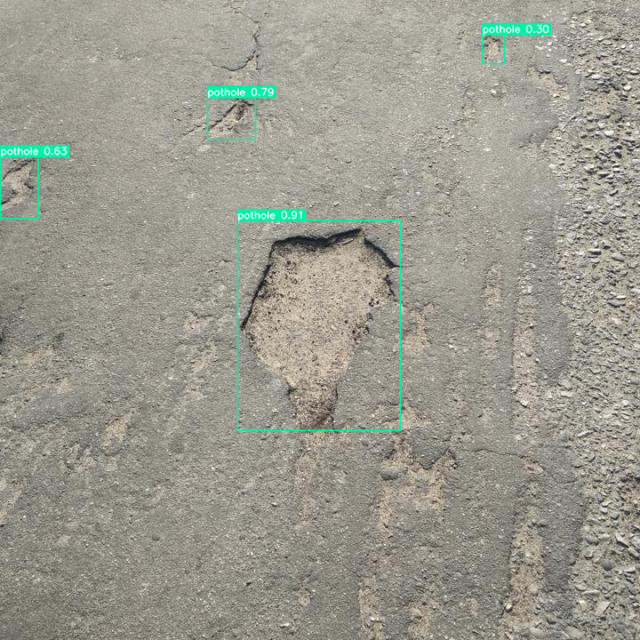

In [27]:
int8_compiled_model = core.compile_model(quantized_model, device.value)
boxes, image, input_shape = detect(int8_compiled_model, './1.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
Image.fromarray(image_with_boxes)

## Validate quantized model accuracy [$\Uparrow$](#Table-of-content:)


In [28]:
int8_result = test(data=data, model=int8_compiled_model, dataloader=dataloader, names=NAMES)

  0%|          | 0/153 [00:00<?, ?it/s]

In [29]:
mp, mr, map50, map, maps, num_images, labels = int8_result

s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         153         381       0.745       0.717        0.78       0.471


## Compare Performance of the Original and Quantized Models [$\Uparrow$](#Table-of-content:)


In [30]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [31]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m best.xml -d $device.value -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 28.50 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output (node: output) : f32 / [...] / [1,25200,6]
[Step 5/11] Resizing model to match i

In [32]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m best_int8.xml -d $device.value -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 78.15 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output (node: output) : f32 / [...] / [1,25200,6]
[Step 5/11] Resizing model to match i